#11장

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

#학습률 스케쥴링

##Power Scheduling

lr = lr0 / (1 + steps / s)**c

In [3]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4) 
# power scheduling 거듭제곱 기반 스케줄링
# lr은 초기값으로 decay 만큼 감소한다.

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [5]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

In [6]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [7]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4850 - accuracy: 0.8295 - val_loss: 0.3981 - val_accuracy: 0.8632
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3758 - accuracy: 0.8655 - val_loss: 0.3821 - val_accuracy: 0.8672
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3454 - accuracy: 0.8771 - val_loss: 0.3624 - val_accuracy: 0.8722
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3245 - accuracy: 0.8835 - val_loss: 0.3519 - val_accuracy: 0.8750
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3090 - accuracy: 0.8895 - val_loss: 0.3432 - val_accuracy: 0.8792
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2971 - accuracy: 0.8939 - val_loss: 0.3402 - val_accuracy: 0.8768
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2866 - accuracy: 0.8983 - val_loss: 0.3397 - val_accurac

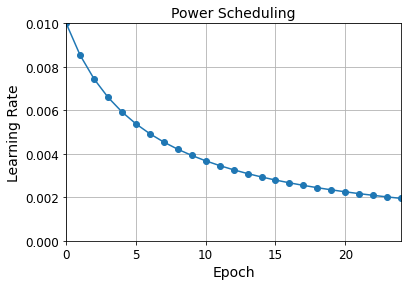

In [8]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

##Exponential Scheduling

lr = lr0 * 0.1**(epoch / s)

In [9]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20) 
#구현 복잡

In [10]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [12]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 19s 10ms/step - loss: 0.8576 - accuracy: 0.7527 - val_loss: 1.0656 - val_accuracy: 0.7394 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7968 - accuracy: 0.7754 - val_loss: 0.8164 - val_accuracy: 0.8054 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6910 - accuracy: 0.8074 - val_loss: 0.6827 - val_accuracy: 0.8272 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6033 - accuracy: 0.8283 - val_loss: 0.8896 - val_accuracy: 0.7762 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5711 - accuracy: 0.8379 - val_loss: 0.6483 - val_accuracy: 0.8226 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4827 - accuracy: 0.8564 - val_loss: 0.6107 - val_accuracy: 0.8488 - lr: 0.0056
Epoch 7/25
1719/1719 [=============================

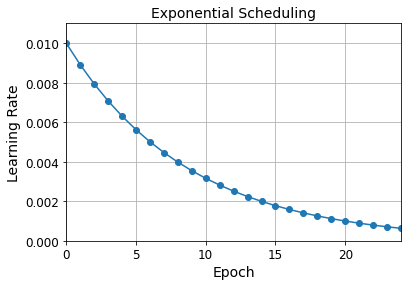

In [13]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

##구간별 고정 스케줄링

훈련 구간 별로 일정한 lr을 정해 놓는 방식.

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

# 함수를 정의하고 각 구간에서 활용할 수 있도록 콜백으로 넘겨줌.
# 구간별로 값을 같게

##성능기반 스케줄링

validation error가 충분히 낮아지면 그때 학습률을 줄여주는 것.

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

##1 Cycle Scheduling

* 이런 방법이 꽤 효과적인 경우가 많았음.
* 처음부터 작게 시작해서 예열을 해서 키운 다음 어느 순간부터 줄임.
* 변수를 최대값, 최소값, 기울기를 넣어줌.

#규제

##L1,L2규제

overfitting을 해결하고자 사용.

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)) 
# 0.01: 규제를 하기 위한 숫자. 계수 값이 커질 수록 규제를 키움.

In [ ]:
from functools import partial
# 케라스 문법은 아님. 

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
#하나로 묶어주는 partial

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                     kernel_regularizer="florot_uniform")
])

##드롭아웃

* 신경망에서만 사용 가능.
* 앙상블 이론과 관련
* 매 훈련 step에서 확률에 따라 각 뉴런을 제외하는 방식. 확률적.
* 모델이 가질 수 있는 다양성을 가지고 데이터에 덜 민감하면서 성능을 키움.
* 모델 출력이 느릴 수 있음.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

#훈련이 끝나면 dropout을 적용하지 않기 때문에 (1-p)를 곱함.
#모든 weight에 곱함.
#averaging 효과
#주로 0.5이하로 씀.
#복잡한 모델일수록 비율을 늘림.

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

##MC Dropout

* 트레이닝과정, 테스트과정을 동일하게 dropout을 동일하게 적용하는 모델

##Max-norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))
# 커널에 대한 제한조건을 주고 최대 norm을 1로 줌.

>최종 목표는 성능이고, 빠르게 훈련할 수 있는 여러 기법들을 배운 것.

#12장-텐서플로를 사용한 사용자 정의 모델과 훈련

* 구글이 만들었음.
* 성능에 장점이 있지만 난이도의 문제가 있었지만 최근들어 접근성이 좋아짐.
* operation 단위. 텐서플로의 연산단위.
* TFX: 사람들이 쉽게 접근해서 사용할 수 있는 환경 구비.
* 넘파이와 구조가 비슷함.

In [ ]:
a = np.array([2., 4., 5.])
tf.constant(a)

In [ ]:
t.numpy()

In [ ]:
np.array(t)

In [ ]:
tf.square(a)

In [ ]:
np.square(t)

In [ ]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)
#자동 형변환을 하지 않음. 타입이 다르면 연산이 되지 않음.

In [ ]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
#모델 상에서 변수의 역할을 하고, 이 상태여야지 객체로써 train이 가능.

##사용자 정의 손실 함수


###Huber loss

In [ ]:
def huber_fn(y_true, y_pred): #참 값과 예측값
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1 # 0 or 1
    squared_loss = tf.square(error) / 2 # 숫자
    linear_loss  = tf.abs(error) - 0.5 # 숫자
    #shape이 같음.
    return tf.where(is_small_error, squared_loss, linear_loss)
    # 삼항 연산자를 사용함.

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
# loss에 function 값 자체를 넣어줌.

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

###Custom component를 가진 모델을 저장하고 로드.

###1. function이름과 실제 function을 매핑한 dictionary 전달.

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})
# custom function은 라이브러리에 저장된 것이 아니라서 정의되지 않았다고 오류
# custom_object에 등록을 해줘서 save/load 가능하게 함.

###2. 매개변수가 있는 function

In [ ]:
def create_huber(threshold=1.0):
  #threshold: 함수 포인터 값.
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss=create_huber(2.0), optimizer="nadam")
# 여기서는 2.0인 구조로 바꿈.

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)}) # 필수

###3. Class 상속

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs): #생성자
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred): #실제 실행
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self): #필요에 따라 변경
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam") 
#아까는 loss에 function이 들어가지만 지금은 생성자

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

## 그 외 사용자 정의 함수

In [ ]:
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights): #규제함수는 꼭 weight를 입력을 받아야 함.
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

> 보통은 가져다 쓰지만 어떤 건지 코드에 대해 알아야 보는 눈을 기를 수 있음.

##사용자 정의 지표_ Custom metric


In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])
# mse 함수 객체
# 보통 metric은 list로 전달
# loss는 하나만, gradient 갯수 대로(하나여야 하니까)

##사용자 정의 층_Custom layer
* init, call, get_config

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

# 상속해서 override 
# init과 call
# build: 모델이 사용되기 전에 호출

In [ ]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05*recon_loss) # 특수한 목적이 있을 때 추가해서 사용. 
        return self.out(Z)

##TF function 사용 규칙

* TF 구성요소가 아닌 다른 라이브러리는 사용하지 않는다.
* 반복문 보다는 백터화된 구현을 사용한다. 횟수 반복은 되지만 값 계산할 때 쓰면 안됨. 작동한다 하더라도 효율이 떨어진다. 
* 명령을 내린다기 보다는 수식을 정의하듯 구현한다.
* Graphical 모델, 행렬연산이라는 컨셉을 유지하도록!
